In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, abspath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.insert(0, abspath("./../../"))

In [4]:
from utils.pandas import apply_filters
from utils_local import colors_v1

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load result file

In [6]:
# csv_path = "../../results/sslvr-action_classification_dataset_size_241221.csv"
# csv_path = "../../results/dataset_size_150122.csv"
# csv_path = "../../results/dataset_size_240122.csv"
csv_path = "../../results/dataset_size_250122.csv"

In [7]:
df = pd.read_csv(csv_path)
df.dropna(inplace=True)

In [8]:
dataset_full_size = {
    "UCF": "9500",
    "NTU": "40300",
    "Gym99": "20500",
    "SS": "169000",
}

In [9]:
for d, v in dataset_full_size.items():
    indices = (df.Dataset == d) * (df["Dataset size"] == "Full")
    df.at[indices, "Dataset size (float)"] = v

In [10]:
df["Dataset size (float)"] = df["Dataset size (float)"].astype(float)

In [11]:
df

,Method,Dataset,Dataset size,Top-1,Dataset size (float)
0,No pretraining,UCF,1000,43.14,NaN
1,SELAVI,UCF,1000,69.18,NaN
2,RSPNET,UCF,1000,75.68,NaN
3,Video Moco,UCF,1000,65.82,NaN
4,Pretext-Contrast,UCF,1000,62.70,NaN
...,...,...,...,...,...
275,CTP,SS,Full,60.16,169000.0
276,TCLR,SS,Full,59.64,169000.0
277,GDT,SS,Full,57.78,169000.0
278,AVID-CMA,SS,Full,53.82,169000.0


### Plot for a single dataset

In [12]:
def lineplot(
        df, x, y,
        ax=None,
        hue="Method",
        style="Method",
        figsize=(10, 8),
        title="Action classification on UCF",
        legend=True,
        titlesize=22,
        labelsize=18,
        legendsize=18,
        tickssize=14,
        linewidth=2.0,
        palette=["lightgray", "gold", "skyblue", "green", "darkorange", "lightseagreen", "blue", "red", "black"],
        markers=None,
        ylim=[30, 100],
        save=False,
        show=True,
        ylabel=None,
        use_custom_yticks=False,
    ):
    if markers is None:
        markers = ["o" for _ in range(len(df[hue].unique()))]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    ax = sns.lineplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        style=style,
        markers=markers,
        ax=ax,
        linewidth=linewidth,
        # linestyle="--",
        palette=palette,
        legend=legend,
        markersize=10,
    )

    ax.grid()
    ax.set_title(title, fontsize=titlesize)
    
    # ax.set_yscale("log")

    if ylim is not None:
        ax.set_ylim(*ylim)

    # low, high = ylim
    # ax.set_yticks(np.linspace(low, high, 20))
    # yticks = np.logspace(low, high, num=10)
    # ax.set_yticks(yticks)

    if legend:
        ax.legend(fontsize=legendsize)
    
    # import ipdb; ipdb.set_trace()
    if use_custom_yticks:
        ax.set_yticks(ticks=ax.get_yticks())
        curr_ticks = ax.get_yticks()
        ax.set_yticks(ticks=np.linspace(curr_ticks[0], curr_ticks[-1], 15))

    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)
    
    ax.set_ylabel(ylabel)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)
    
    if save:
        plt.savefig("../../results/plots/action_classification_ucf_datasetsize.pdf", bbox_inches="tight")
    
    if show:
        plt.show()
    
    return ax

### Plot multiple datasets together

In [13]:
def linesubplots(df, ykey="Top-1", save=False, path="../../results/plots/lineplot.pdf"):
    datasets = df.Dataset.unique()
    fig, axes = plt.subplots(1, len(datasets), figsize=(20, 5))

    for i in range(len(axes)):
        sub_df = df[df["Dataset"] == datasets[i]].copy()
        
        ylabel = "Top-1" if i == 0 else None
        legend = True if i == 1 else False

        ax = lineplot(
            sub_df,
            x="Dataset size",
            y=ykey,
            title=datasets[i],
            ax=axes[i],
            palette=colors_v1,
            legend=legend,
            legendsize=12,
            show=False,
            # ylim=[sub_df[ykey].min() - 5, sub_df[ykey].max() + 5],
            ylim=None,
            # ylim=[sub_df[ykey].min() - 5, 90],
            ylabel=ylabel,
        )
    
    if save:
        plt.savefig(path, bbox_inches="tight")

    plt.show()

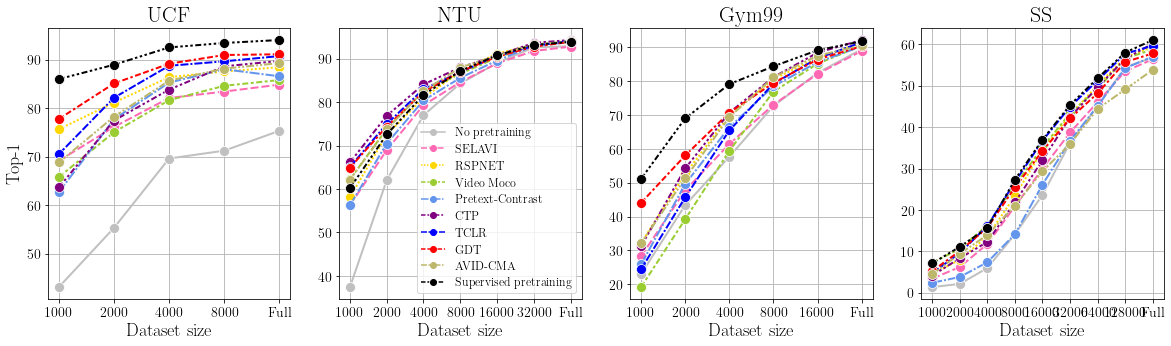

In [14]:
linesubplots(df, "Top-1", save=True, path="../../results/plots/domain_shift-dataset_size.pdf")

### Heatmaps

In [15]:
def heatmap(
        df,
        ax=None,
        figsize=(7, 6),
        title="Action classification",
        titlesize=20,
        labelsize=15,
        tickssize=13,
        save=False,
        save_path="../../results/plots/sample.pdf",
        show=True,
        **kwargs,
    ):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if "cmap" not in kwargs:
        kwargs.update(dict(cmap="YlGnBu"))
    sns.heatmap(df, ax=ax, **kwargs)

    ax.set_title(title, fontsize=titlesize)

    ax.set_xlabel("Dataset")
    ax.set_ylabel("Method")
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)
    
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    if show:
        plt.show()

### Average

In [16]:
mean_df = pd.DataFrame(None, index=df.Method.unique(), columns=df.Dataset.unique())
stdv_df = pd.DataFrame(None, index=df.Method.unique(), columns=df.Dataset.unique())

datasets = df.Dataset.unique()
for i, d in enumerate(datasets):
    mean_df[d] = apply_filters(df, {"Dataset": d}, reset_index=False).groupby("Method")["Top-1"].mean()
    stdv_df[d] = apply_filters(df, {"Dataset": d}, reset_index=False).groupby("Method")["Top-1"].std()

In [17]:
mean_df.reset_index()

,index,UCF,NTU,Gym99,SS
0,No pretraining,62.954,76.462857,61.451667,26.653333
1,SELAVI,79.160,80.372857,63.596667,29.650000
2,RSPNET,83.192,82.430000,68.905000,32.578889
3,Video Moco,78.608,83.224286,61.741667,33.688889
4,Pretext-Contrast,80.078,81.301429,66.056667,27.437778
5,CTP,80.692,84.821429,69.663333,31.924444
6,TCLR,84.392,83.954286,65.521667,34.165556
7,GDT,86.848,83.692857,71.516667,32.723333
8,AVID-CMA,82.060,83.498571,68.680000,29.056667
9,Supervised pretraining,91.020,82.778571,77.438333,34.924444


In [18]:
mean_flat_df =pd.melt(mean_df.reset_index(), id_vars=["index"])
stdv_flat_df =pd.melt(stdv_df.reset_index(), id_vars=["index"])

In [19]:
combined = pd.merge(mean_flat_df, stdv_flat_df, on=["index", "variable"])
combined.rename(columns={"value_x": "mean", "value_y": "std"}, inplace=True)

In [20]:
sns.barplot(data=apply_filters(combined, {"variable": "UCF"}), x="index", y="mean", y_e)

SyntaxError: positional argument follows keyword argument (1749656970.py, line 1)

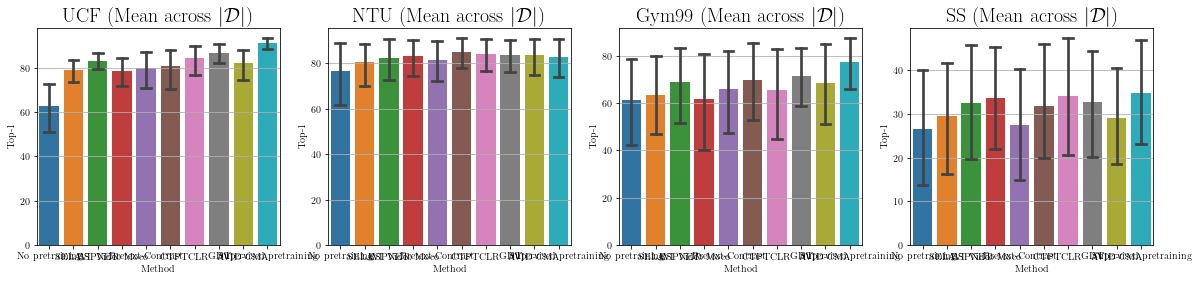

In [21]:
datasets = df.Dataset.unique()

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i, d in enumerate(datasets):
    ax = axes[i]

    ax.grid()
    ax.set_title(f"{d} " + "(Mean across $|\mathcal{D}|$)", fontsize=20)
    sns.barplot(
        data=apply_filters(df, {"Dataset": d}),
        x="Method",
        y="Top-1",
        estimator=np.mean,
        # ci=100,
        capsize=.4,
        ax=ax,
    )

plt.show()

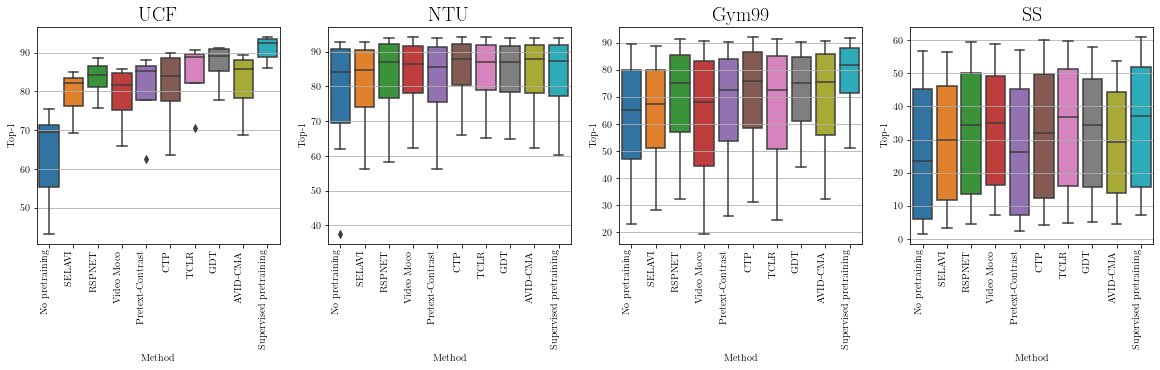

In [22]:
datasets = df.Dataset.unique()

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i, d in enumerate(datasets):
    ax = axes[i]

    ax.grid()
    ax.set_title(d, fontsize=20)
    sns.boxplot(
        data=apply_filters(df, {"Dataset": d}),
        x="Method",
        y="Top-1",
        # estimator=np.mean,
        # ci=100,
        # capsize=.4,
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

<AxesSubplot:xlabel='Method', ylabel='Top-1'>

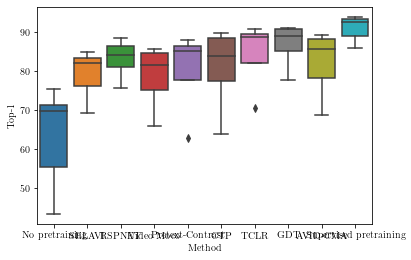

In [23]:
sns.boxplot(data=apply_filters(df, {"Dataset": "UCF"}), x="Method", y="Top-1")

<AxesSubplot:>

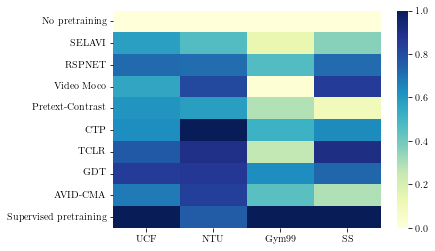

In [24]:
norm_mean_df = (mean_df - mean_df.min())/(mean_df.max() - mean_df.min())
sns.heatmap(norm_mean_df, cmap="YlGnBu")

In [25]:
apply_filters(df, {"Dataset": "UCF"}, reset_index=False).groupby("Method")["Top-1"].mean()

Method
AVID-CMA                  82.060
CTP                       80.692
GDT                       86.848
No pretraining            62.954
Pretext-Contrast          80.078
RSPNET                    83.192
SELAVI                    79.160
Supervised pretraining    91.020
TCLR                      84.392
Video Moco                78.608
Name: Top-1, dtype: float64

In [26]:
mean_df

,UCF,NTU,Gym99,SS
No pretraining,62.954,76.462857,61.451667,26.653333
SELAVI,79.160,80.372857,63.596667,29.650000
RSPNET,83.192,82.430000,68.905000,32.578889
Video Moco,78.608,83.224286,61.741667,33.688889
Pretext-Contrast,80.078,81.301429,66.056667,27.437778
CTP,80.692,84.821429,69.663333,31.924444
TCLR,84.392,83.954286,65.521667,34.165556
GDT,86.848,83.692857,71.516667,32.723333
AVID-CMA,82.060,83.498571,68.680000,29.056667
Supervised pretraining,91.020,82.778571,77.438333,34.924444


### Final plot

In [27]:
dataset_sizes = ["1000", "2000", "4000", "8000"]

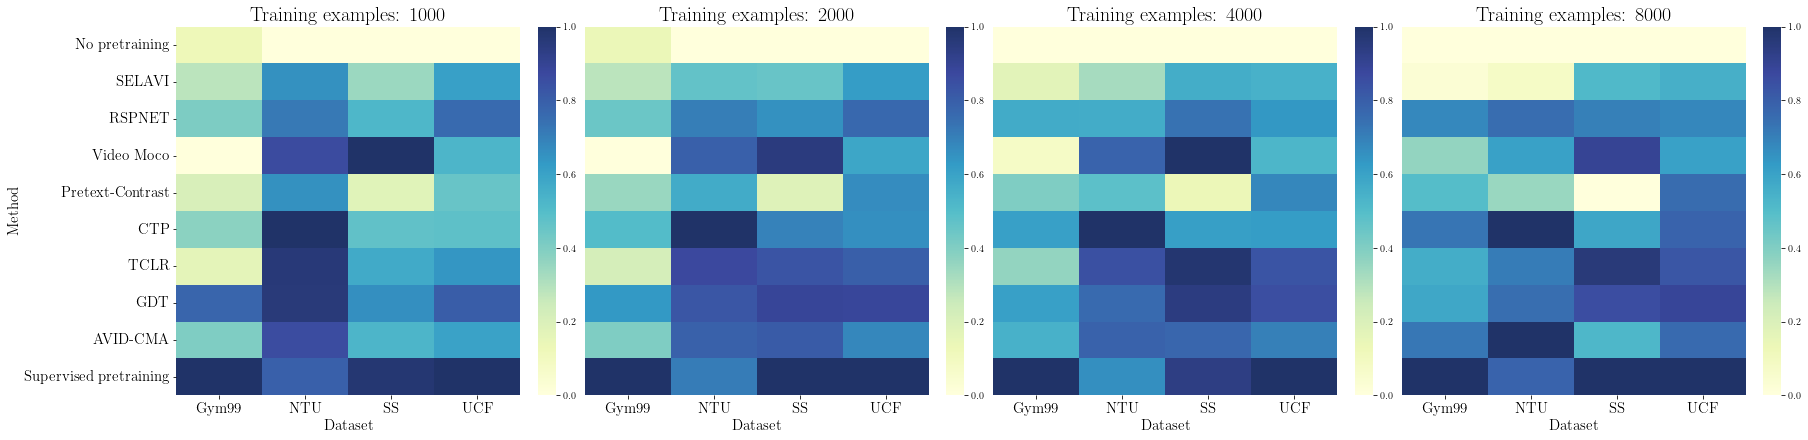

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6), constrained_layout=True)

for i, ds in enumerate(dataset_sizes):
    ax = axes[i]
    
    subdf = apply_filters(df, {"Dataset size": ds})
    pivot_df = subdf.pivot_table(index="Method", columns="Dataset")["Top-1"]
    normalized_df=(pivot_df-pivot_df.min())/(pivot_df.max()-pivot_df.min())
    normalized_df = normalized_df.reindex(list(df.Method.unique()))

    heatmap(
        normalized_df,
        ax=ax,
        title=f"Training examples: {ds}",
        titlesize=20,
        labelsize=15,
        tickssize=15,
        save=False,
        cmap="YlGnBu",
        alpha=0.9,
        # annot=annot,
        fmt='g',
        annot_kws={"size": 19},
        show=False,
    )
    
    if i > 0:
        ax.set_ylabel("")
        ax.set_yticks([])

plt.savefig("../../results/plots/training_dataset_size_heatmaps.pdf")
plt.show()

### Plot single dataset

In [15]:
df.Dataset.unique()

array(['UCF', 'NTU', 'Gym99', 'SS'], dtype=object)

In [16]:
import os

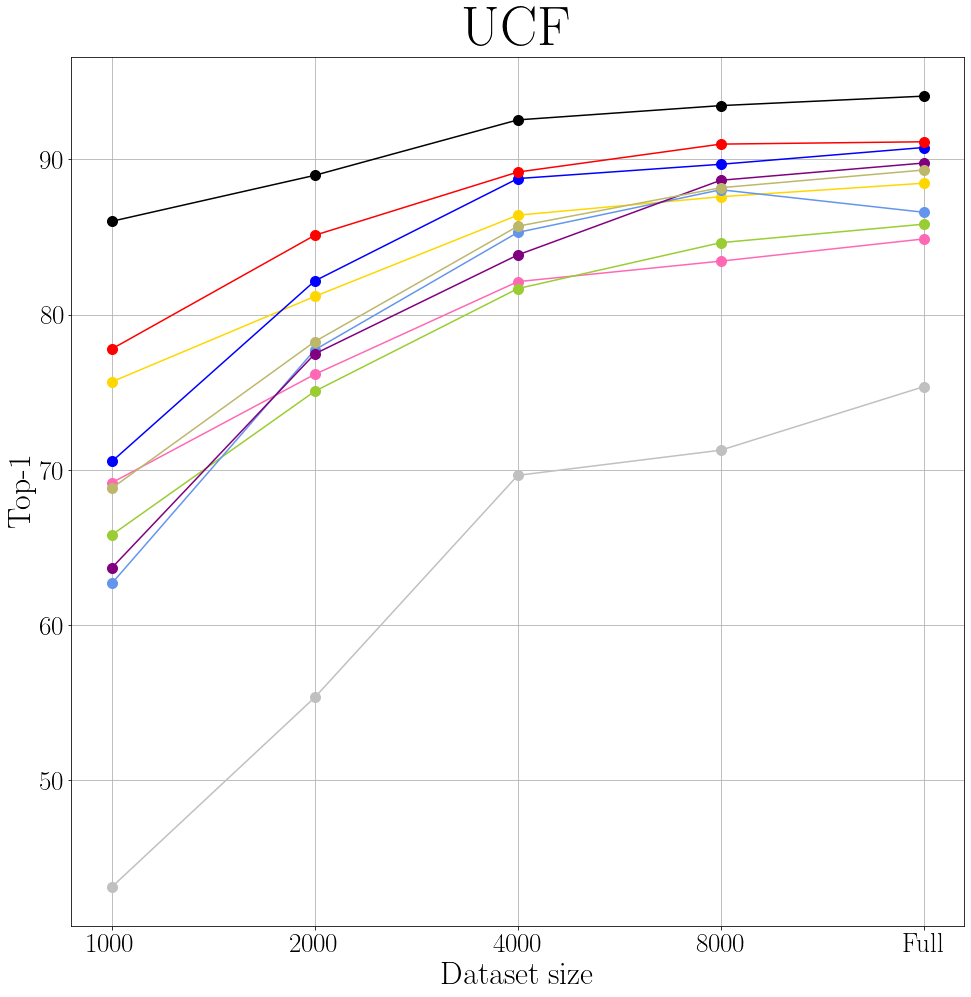

In [17]:
dataset = "UCF"

sub_df = df[df["Dataset"] == dataset]

methods = list(sub_df.Method.unique())

W=16
H=16
figsize=(W, H)

titlesize = W * 3.5
legendsize = W * 2.2
xlabelsize = W * 2.0
ylabelsize = H * 2.0
xtickssize = W * 1.7
ytickssize = H * 1.7

linewidth = 1.5
markersize = 10.0
legend = False

x = "Dataset size"
y = "Top-1"

# colors=["gray", "gold", "skyblue", "green", "darkorange", "lightseagreen", "blue", "red", "black"]
# colors = ["silver", "hotpink", "gold", "yellowgreen", "cornflowerblue", "purple", "blue", "red", "", "black"]
# colors = ["darkgray", "violet", "indigo", "blue", "green", "gold", "orange", "red", "black"]
colors = colors_v1

fig, ax = plt.subplots(figsize=figsize)

for i, m in enumerate(methods):
    subsub_df = apply_filters(sub_df, {"Method": m})
    ax.plot(
        subsub_df[x],
        subsub_df['Top-1'],
        label=m, marker="o", markersize=markersize, linewidth=linewidth, color=colors[i],
    )

ax.set_title(dataset, fontsize=titlesize)

ax.set_xlabel(x, fontsize=xlabelsize)
ax.tick_params(axis='x', labelsize=xtickssize)

ax.set_ylabel(y, fontsize=xlabelsize)
ax.tick_params(axis='y', labelsize=ytickssize)

ax.grid()
if legend:
    ax.legend(fontsize=legendsize)

save_path = f"../../results/plots/domain_shift_{dataset}_v2.pdf"
os.system(f"rm -rf {save_path}")
plt.savefig(save_path, bbox_inches="tight")
plt.show()

In [19]:
datasets = list(df.Dataset.unique())

In [20]:
from utils_local import colors_v1 as colors

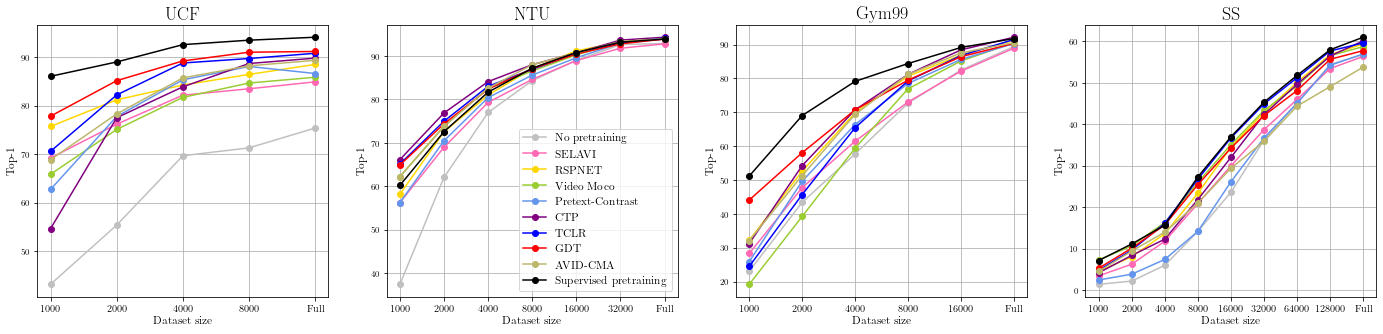

In [21]:
W=6
H=5
figsize=(4 * W, H)

titlesize = W * 3.0
legendsize = W * 1.9
xlabelsize = W * 1.9
ylabelsize = H * 1.9
xtickssize = W * 1.7
ytickssize = H * 1.7

fig, axes = plt.subplots(1, 4, figsize=figsize)

for j, d in enumerate(datasets):
    ax = axes[j]
    sub_df = apply_filters(df, {"Dataset": d})
    for i, m in enumerate(methods):
        subsub_df = apply_filters(sub_df, {"Method": m})
        ax.plot(subsub_df['Dataset size'], subsub_df['Top-1'], label=m, marker="o", markersize=6, linewidth=1.5, color=colors[i])

    ax.set_title(d, fontsize=titlesize)

    ax.set_xlabel("Dataset size", fontsize=xlabelsize)
    ax.tick_params(axis='x', labelsize=xtickssize)

    ax.set_ylabel("Top-1", fontsize=xlabelsize)
    ax.tick_params(axis='y', labelsize=ytickssize)

    ax.grid()
    if j == 1:
        ax.legend(fontsize=legendsize)

plt.show()

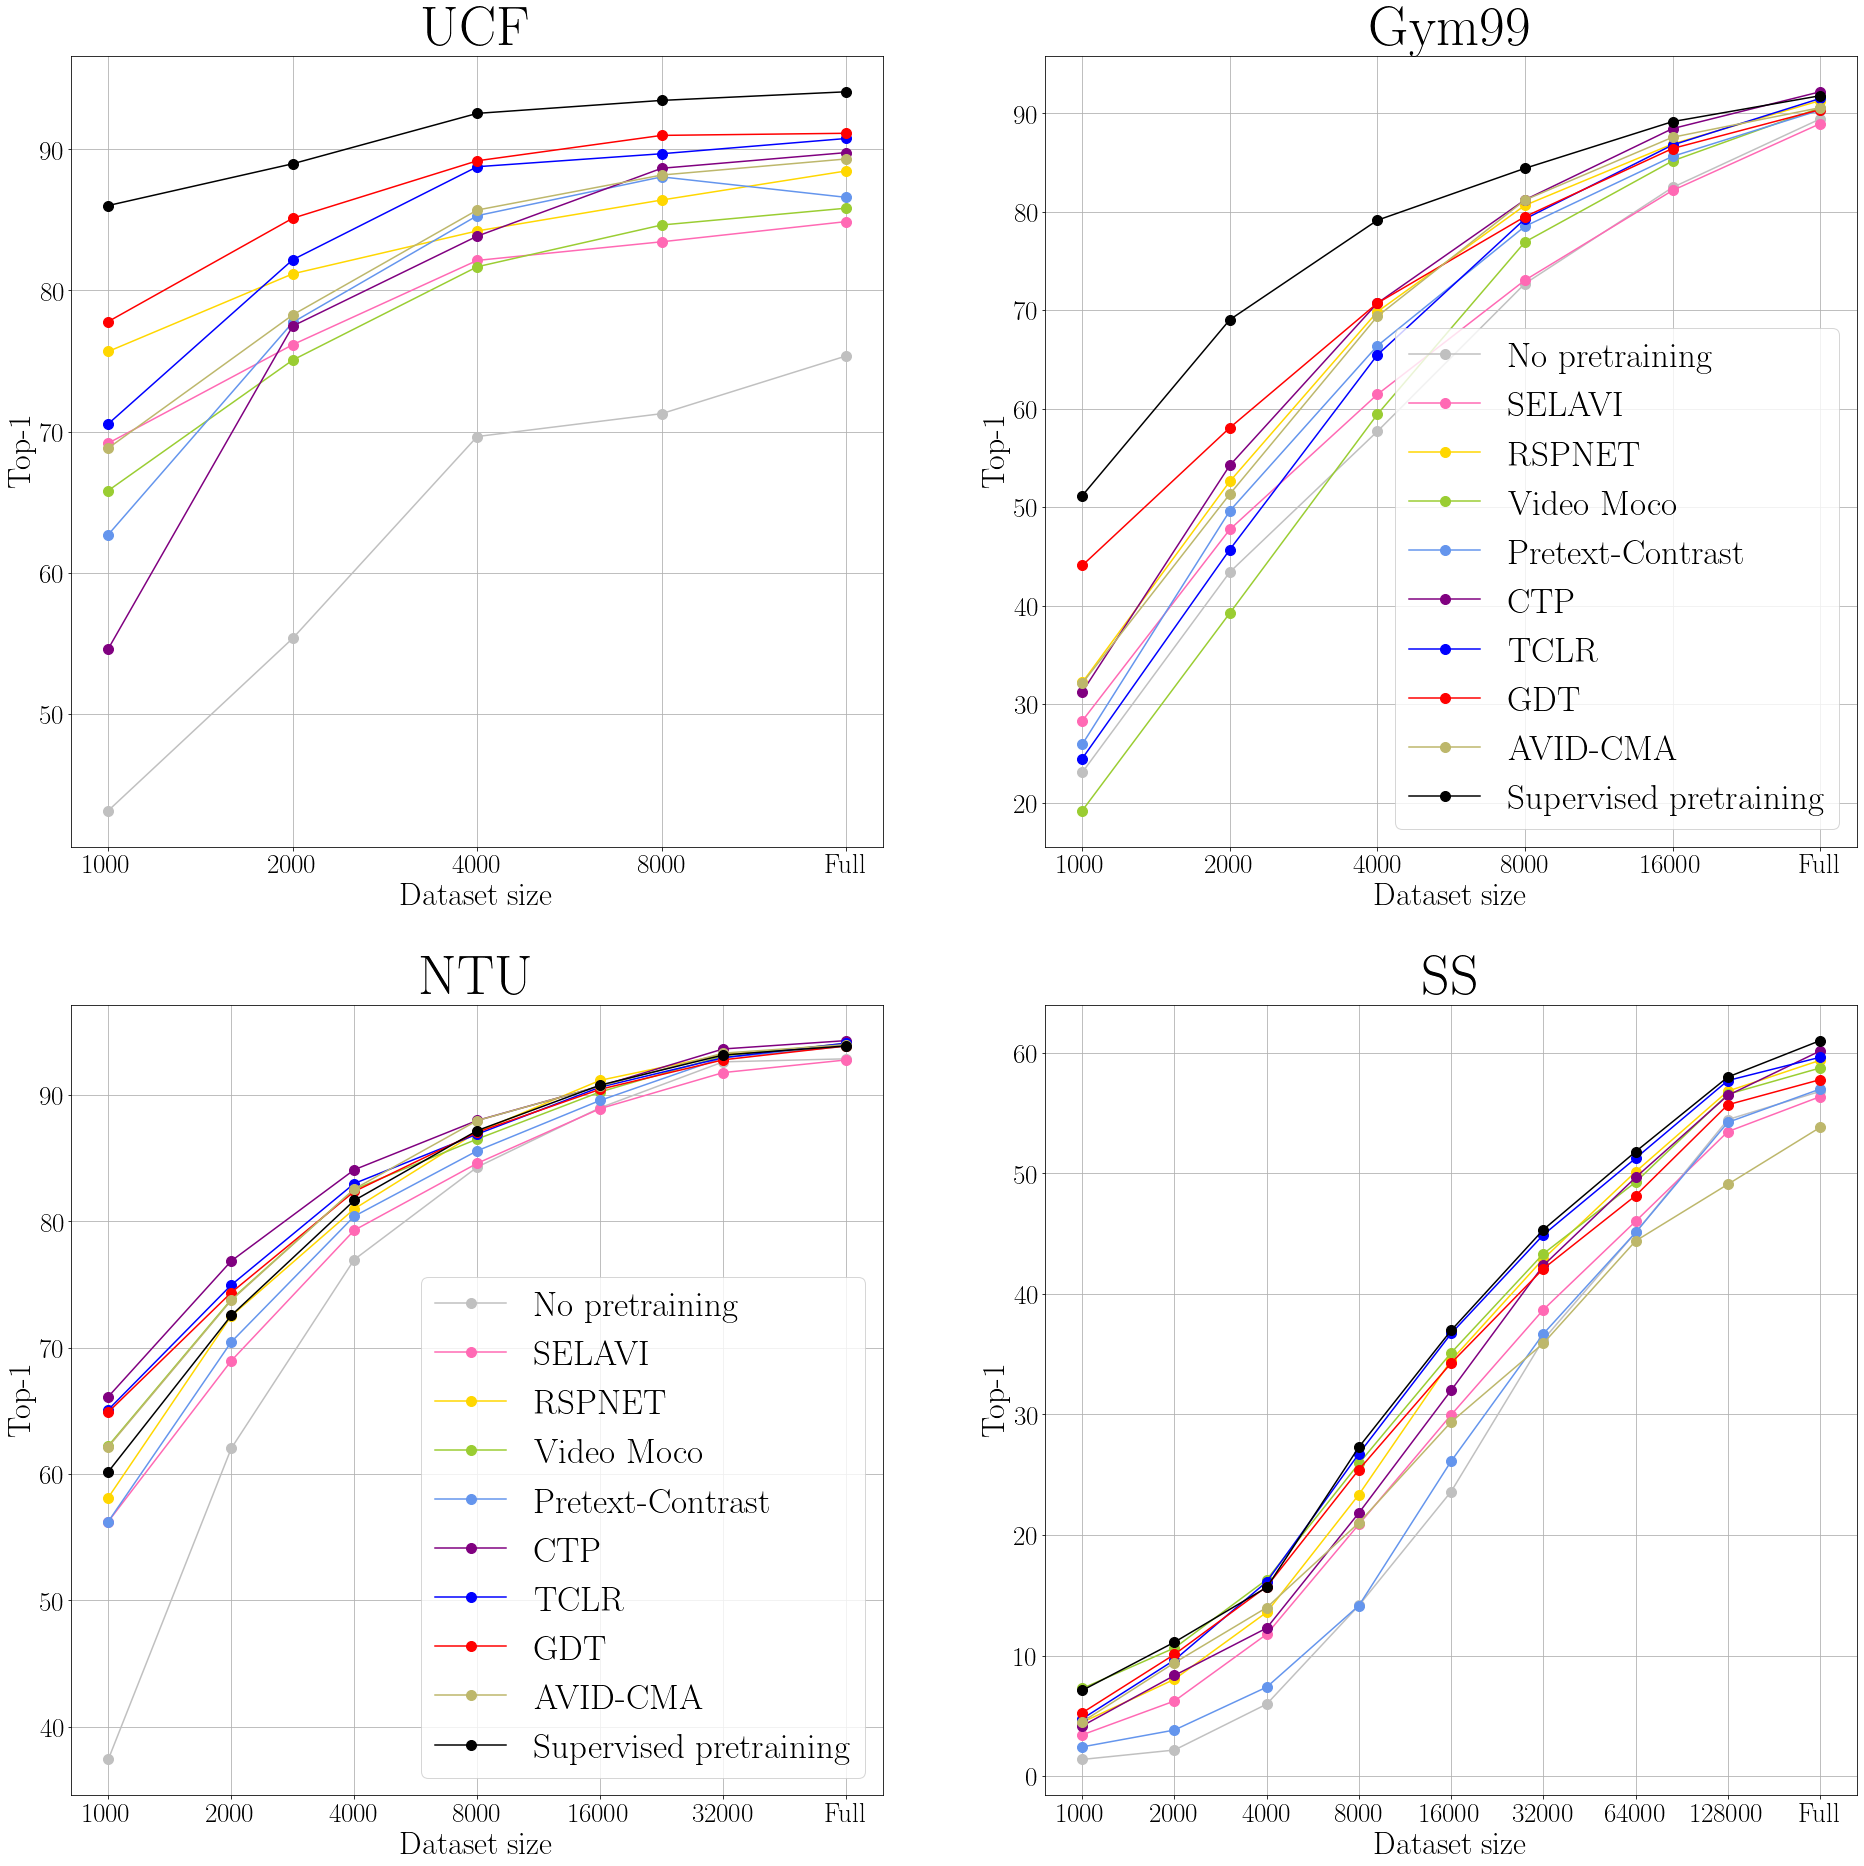

In [23]:
W=16
H=16
figsize=(2 * W, 2 * H)

titlesize = W * 3.5
legendsize = W * 2.2
xlabelsize = W * 2.0
ylabelsize = H * 2.0
xtickssize = W * 1.7
ytickssize = H * 1.7

linewidth = 1.5
markersize = 10.0
legend = False

x = "Dataset size (float)"
x = "Dataset size"
y = "Top-1"

fig, axes = plt.subplots(2, 2, figsize=figsize)


for j, d in enumerate(datasets):
    ax = axes[j%2, j//2]
    
    sub_df = apply_filters(df, {"Dataset": d})
    for i, m in enumerate(methods):
        subsub_df = apply_filters(sub_df, {"Method": m})
        ax.plot(
            subsub_df[x], subsub_df[y],
            label=m, marker="o", markersize=markersize, linewidth=linewidth, color=colors[i],
        )

    ax.set_title(d, fontsize=titlesize)
    
    # if j in [1, 3]:
    #     ax.set_xlabel(x, fontsize=xlabelsize)
    ax.set_xlabel(x, fontsize=xlabelsize)
    ax.tick_params(axis='x', labelsize=xtickssize)
    
    
    ax.set_ylabel("Top-1", fontsize=xlabelsize)
    ax.tick_params(axis='y', labelsize=ytickssize)

    ax.grid()
    if j == 1 or j == 2:
        ax.legend(fontsize=legendsize)

plt.savefig("../../results/plots/domain_shift_few_shot-2x2_grid_v2.pdf", bbox_inches="tight")
plt.show()

## Junk

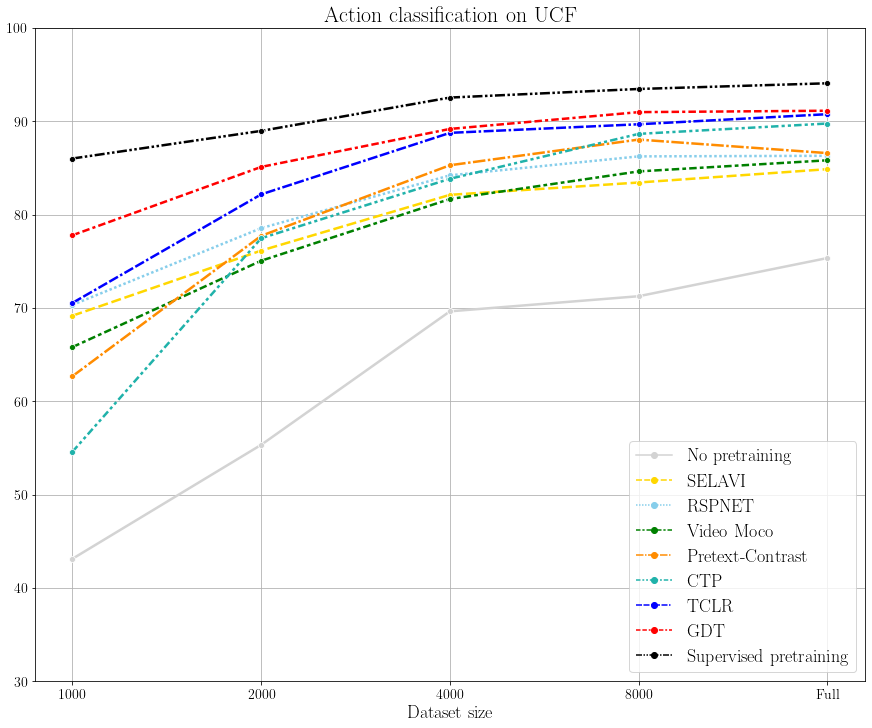

<AxesSubplot:title={'center':'Action classification on UCF'}, xlabel='Dataset size'>

In [67]:
lineplot(sub_df, x="Dataset size", y="Top-1", ylim=[30, 100], figsize=(12, 10))

In [67]:
sub_df = df[df["Dataset"] == "NTU"]

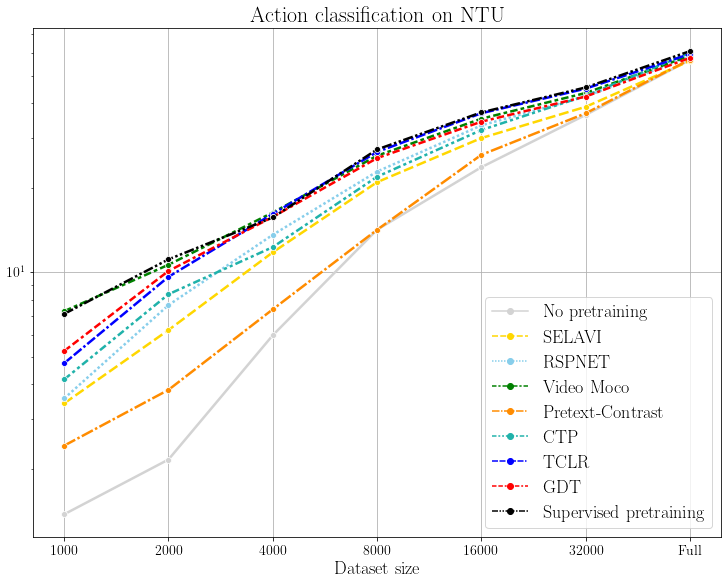

<AxesSubplot:title={'center':'Action classification on NTU'}, xlabel='Dataset size'>

In [71]:
lineplot(sub_df, x="Dataset size", y="Top-1", title="Action classification on NTU")

In [12]:
sub_df = df[df["Dataset"] == "Gym99"]

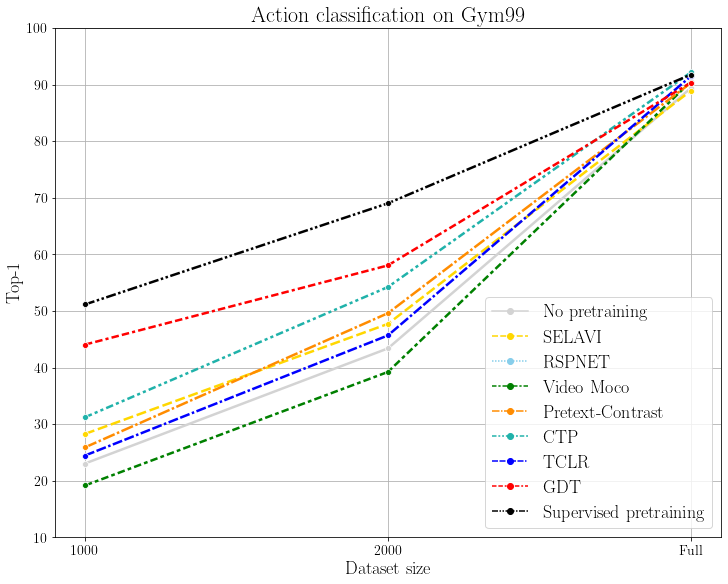

In [13]:
lineplot(sub_df, x="Dataset size", y="Top-1", title="Action classification on Gym99", ylim=[10, 100])

In [15]:
sub_df = df[df["Dataset"] == "SS"]

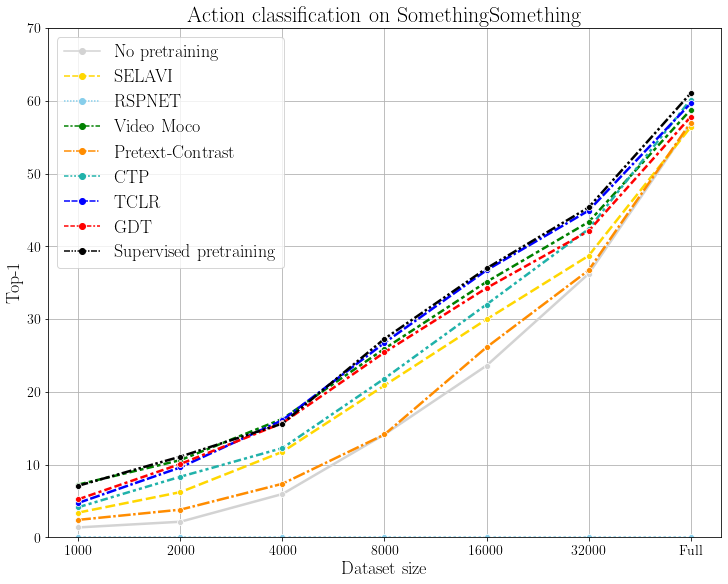

In [18]:
lineplot(sub_df, x="Dataset size", y="Top-1", title="Action classification on SomethingSomething", ylim=[0, 70])

### Rank-correlation

In [19]:
from scipy import stats

In [20]:
dataset_sizes = list(df["Dataset size"].unique())

In [21]:
rank_cor_per_size = dict()

for s in dataset_sizes:
    sub_df = apply_filters(df, {"Dataset size": s})

    datasets = list(sub_df.Dataset.unique())
    rank_cor = dict()

    for d in datasets:
        if d == "UCF":
            continue
        src = apply_filters(sub_df, {"Dataset": "UCF"})["Top-1"].argsort().values
        dst = apply_filters(sub_df, {"Dataset": d})["Top-1"].argsort().values
        if len(src) and len(dst):
            rank_cor[d] = stats.spearmanr(src, dst).correlation
    
    rank_cor_per_size[s] = rank_cor

In [22]:
pd.DataFrame(rank_cor_per_size).dropna(axis=1)

,1000,2000,4000,8000,Full
NTU,0.350000,0.583333,0.283333,0.883333,0.633333
Gym99,0.650000,0.716667,0.983333,0.816667,0.616667
SS,0.416667,0.633333,0.633333,0.600000,0.666667
